# Demand Forecaster with Tensorflow

## 1) Business problem

URL Project: [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=test.csv)

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

**Data Dictionary**

We have a train (8523) and test (5681) data set, the train data set has both input and output variable(s). You need to predict the sales for the test data set.

#### Train file:
CSV containing the item outlet information with a sales value

**Variable Description**
* *Item_Identifier*: Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*: Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*: Maximum Retail Price (list price) of the product
* *Outlet_Identifier*: Unique store ID
* *Outlet_Establishment_Year*: The year in which the store was established
* *Outlet_Size*: The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
* *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

### Test file:
CSV containing item outlet combinations for which sales need to be forecasted

**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*:  Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*:  Maximum Retail Price (list price) of the product
* *Outlet_Identifier*:  Unique store ID
* *Outlet_Establishment_Year*:  The year in which store store was established
* *Outlet_Size*:  The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: whether the outlet is just a grocery store or some sort of supermarket

### Submission file format
**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Outlet_Identifier*:  Unique store ID
* *Item_Outlet_Sales*:  Sales of the product in t particular store. This is the outcome variable to be predicted.

**Evaluation Metric**

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in the same sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

### 1.1) Imports and Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context("paper")

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf

tf.__version__

'2.15.0'

### 1.2) Utilities Functions

In [4]:
def currencyFormatting(value):
    if value / 1000000 > 1:
        return f'$ {str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'$ {str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'$ {str(round(value/10000, 2))}k'
    else: 
        return f'$ {str(round(value, 2))}'

In [5]:
def resumeNumber(value):
    if value / 1000000 > 1:
        return f'{str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'{str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'{str(round(value/10000, 2))}k'
    else: 
        return f'{str(round(value, 2))}'

### 1.3) Load data

In [6]:
df_train_raw = pd.read_parquet('../data/x_train_transformed.parquet', engine='pyarrow')
df_test_raw = pd.read_parquet('../data/x_test_transformed.parquet', engine='pyarrow')

In [7]:
display(df_train_raw.shape)
display(df_train_raw.head(2))
display(df_test_raw.shape)
display(df_test_raw.head(2))

(6392, 25)

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales
0,7,9.13,1,0.051953,152.3024,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.6288
1,6,20.60,0,0.047927,185.9556,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4318.3788


(2131, 25)

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales
0,8,17.75,0,0.156832,241.0538,0.0,0.0,0.33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1201.7690
1,2,18.50,0,0.062609,148.6418,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1765.7016


## 2) Seleção de Atributos

In [30]:
feature_columns = [
    'Outlet_Identifier_ordinal', 
    'Item_Weight', 
    'Item_Fat_Content', 
    'Item_Visibility', 
    'Item_MRP', 
    'Outlet_Size', 
    'Outlet_Location_Type', 
    'Outlet_Type', 
    'Item_Type_Baking_Goods', 
    'Item_Type_Breads', 
    'Item_Type_Breakfast', 
    'Item_Type_Canned', 
    'Item_Type_Dairy', 
    'Item_Type_Frozen_Foods', 
    'Item_Type_Fruits_and_Vegetables', 
    'Item_Type_Hard_Drinks', 
    'Item_Type_Health_and_Hygiene', 
    'Item_Type_Household', 
    'Item_Type_Meat', 
    'Item_Type_Others', 
    'Item_Type_Seafood', 
    'Item_Type_Snack_Foods', 
    'Item_Type_Soft_Drinks', 
    'Item_Type_Starchy_Foods', 
]

target_column = 'Outlet_Sales'

## 3) Padronização dos Dados

In [31]:
standard_scaler = StandardScaler()

x_train_scaled = standard_scaler.fit_transform(df_train_raw[feature_columns])
x_test_scaled = standard_scaler.transform(df_test_raw[feature_columns])

In [32]:
X = x_train_scaled
y = df_train_raw[target_column]

X_test = x_test_scaled
y_test = df_test_raw[target_column]

display((X, y))
print(len(X))

(array([[ 0.80484744, -0.88507264,  0.7302201 , ..., -0.40716723,
         -0.23665436, -0.13047859],
        [ 0.45230959,  1.82624024, -1.36945011, ..., -0.40716723,
         -0.23665436, -0.13047859],
        [ 1.15738529, -0.49031305, -1.36945011, ..., -0.40716723,
         -0.23665436, -0.13047859],
        ...,
        [ 0.45230959, -0.05300452,  0.7302201 , ..., -0.40716723,
         -0.23665436, -0.13047859],
        [-0.95784181,  0.18337847,  0.7302201 , ..., -0.40716723,
         -0.23665436, -0.13047859],
        [-0.60530396, -1.05290456,  0.7302201 , ..., -0.40716723,
         -0.23665436, -0.13047859]]),
 0       1821.6288
 1       4318.3788
 2        690.4346
 3       4264.4490
 4       3745.1250
           ...    
 6387    3149.2340
 6388    2404.8696
 6389    2679.8450
 6390    2846.2950
 6391     830.9184
 Name: Outlet_Sales, Length: 6392, dtype: float64)

6392


## 4) Primeira modelagem

### 4.1) Métricas de Avaliação

**Erro Percentual Absoluto Médio (MAPE)**
*  Significado: o Erro Percentual Absoluto Médio é a média do percentual absoluto de erros de previsão em relação aos valores observados.
*  Fórmula: $\text{MAPE} = \text{média} (|\text{PE}|)$
*  Interpretação: um MAPE igual a zero indica que o modelo prevê perfeitamente os dados; quanto maior o valor de MAPE, maior a discrepância entre os valores observados e previstos.


**R²**
* A métrica R², também conhecida como R-dois ou coeficiente de determinação, representa o percentual da variância dos dados que é explicado pelo modelo. Os resultados variam de 0 a 1, geralmente também são expressos em termos percentuais, ou seja, variando entre 0% e 100%. Quanto maior é o valor de R², mais explicativo é o modelo em relação aos dados previstos. Na equação 2 é mostrado o cálculo desta métrica, no qual y e ŷ os valores reais e previstos, respectivamente, e y-barra representa a média dos valores reais.

$$
R^2 = 1 - \frac{{\text{{Soma dos Quadrados dos Resíduos (SQRes)}}}}{{\text{{Soma Total dos Quadrados (SQT)}}}}
$$

* Onde:
- **SQRes** é a soma dos quadrados dos resíduos (ou erros) entre os valores previstos pelo modelo e os valores reais observados.
- **SQT** é a soma total dos quadrados, que representa a variabilidade total dos dados em relação à média.

* Porém, utilizando somente esta métrica, será que um valor de 0,5 já seria o suficiente para colocar o modelo em produção? Faz-se necessário aproximar ainda mais o seu resultado para 1? Para responder a essa e outras perguntas, deve-se sempre utilizar outras métricas para se ter uma visão global sobre a performance do modelo.

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_absolute_percentage_error', optimizer='sgd')
history = model.fit(X, y, epochs=200)

Epoch 1/200
200/200 [==============================] - 0s 571us/step - loss: 99.8131
Epoch 2/200
200/200 [==============================] - 0s 533us/step - loss: 95.8785
Epoch 3/200
200/200 [==============================] - 0s 549us/step - loss: 73.0168
Epoch 4/200
200/200 [==============================] - 0s 542us/step - loss: 55.3895
Epoch 5/200
200/200 [==============================] - 0s 552us/step - loss: 53.6247
Epoch 6/200
200/200 [==============================] - 0s 603us/step - loss: 51.8052
Epoch 7/200
200/200 [==============================] - 0s 560us/step - loss: 50.3758
Epoch 8/200
200/200 [==============================] - 0s 545us/step - loss: 49.1590
Epoch 9/200
200/200 [==============================] - 0s 554us/step - loss: 48.2360
Epoch 10/200
200/200 [==============================] - 0s 561us/step - loss: 47.7242
Epoch 11/200
200/200 [==============================] - 0s 535us/step - loss: 47.2486
Epoch 12/200
200/200 [==============================] - 0s 533u

In [29]:
mse_test = model.evaluate(X_test, y_test)

67/67 [==============================] - 0s 641us/step - loss: 48.4251


In [13]:
predict_train = model.predict(X)

df_train_raw['Predicted'] = predict_train
df_train_raw.head()

200/200 [==============================] - 0s 472us/step


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Predicted
0,7,9.13,1,0.051953,152.3024,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.6288,1848.250366
1,6,20.60,0,0.047927,185.9556,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4318.3788,2431.483643
2,8,10.80,0,0.048143,40.2138,0.0,0.0,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,690.4346,524.191101
3,8,9.21,1,0.008765,123.1414,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4264.4490,1608.377441
4,3,17.35,0,0.146896,149.6050,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3745.1250,1432.369873


In [14]:
predict_test = model.predict(X_test)

df_test_raw['Predicted'] = predict_test
df_test_raw.head()

67/67 [==============================] - 0s 469us/step


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Predicted
0,8,17.75,0,0.156832,241.0538,0.0,0.0,0.33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1201.7690,3388.182373
1,2,18.50,0,0.062609,148.6418,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1765.7016,1815.901855
2,3,7.67,1,0.185597,35.7216,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69.2432,234.686142
3,8,6.36,1,0.120544,45.8060,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1165.1500,791.666870
4,6,6.28,1,0.027700,87.9198,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1221.0772,1339.390869


In [15]:
train_mape = mean_absolute_percentage_error(df_train_raw['Outlet_Sales'], df_train_raw['Predicted'])
test_mape = mean_absolute_percentage_error(df_test_raw['Outlet_Sales'], df_test_raw['Predicted'])
train_mape, test_mape

(0.4018025791537301, 0.4726630229132854)

In [16]:
train_r2 = r2_score(df_train_raw['Outlet_Sales'], df_train_raw['Predicted'])
test_r2 = r2_score(df_test_raw['Outlet_Sales'], df_test_raw['Predicted'])
train_r2, test_r2

(0.46810465929378287, 0.425219383456349)

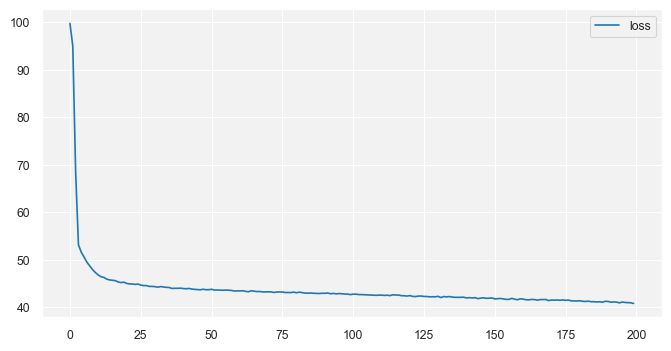

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,4))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

---

In [56]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='elu', input_shape=X.shape[1:]),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(200, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(48, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(1)
])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, use_ema=True)

model.compile(optimizer=adam, loss='mape')

history = model.fit(x=X, y=y, epochs=500, callbacks=[checkpoint_cb, early_stopping], validation_data=(X_test, y_test))

Epoch 1/500
200/200 [==============================] - 1s 2ms/step - loss: 89.0825 - val_loss: 69.8707
Epoch 2/500
200/200 [==============================] - 0s 2ms/step - loss: 58.8741 - val_loss: 53.3143
Epoch 3/500
200/200 [==============================] - 0s 2ms/step - loss: 55.0449 - val_loss: 52.9287
Epoch 4/500
200/200 [==============================] - 0s 2ms/step - loss: 54.1633 - val_loss: 53.4641
Epoch 5/500
200/200 [==============================] - 0s 2ms/step - loss: 53.3870 - val_loss: 51.6728
Epoch 6/500
200/200 [==============================] - 0s 2ms/step - loss: 52.9273 - val_loss: 50.9190
Epoch 7/500
200/200 [==============================] - 0s 2ms/step - loss: 51.9830 - val_loss: 50.1908
Epoch 8/500
200/200 [==============================] - 0s 2ms/step - loss: 51.1419 - val_loss: 49.3875
Epoch 9/500
200/200 [==============================] - 0s 2ms/step - loss: 49.9695 - val_loss: 48.0910
Epoch 10/500
200/200 [==============================] - 0s 2ms/step - los

In [57]:
mse_test = model.evaluate(X_test, y_test)

67/67 [==============================] - 0s 596us/step - loss: 45.4930


In [58]:
predict_train = model.predict(X)
predict_test = model.predict(X_test)

df_train_raw['Predicted'] = predict_train
df_test_raw['Predicted'] = predict_test

display(df_train_raw.head(3))
display(df_test_raw.head(3))

67/67 [==============================] - 0s 520us/step


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Predicted
0,7,9.13,1,0.051953,152.3024,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.6288,1810.158936
1,6,20.60,0,0.047927,185.9556,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4318.3788,2382.313232
2,8,10.80,0,0.048143,40.2138,0.0,0.0,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,690.4346,482.855713


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods,Outlet_Sales,Predicted
0,8,17.75,0,0.156832,241.0538,0.0,0.0,0.33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1201.7690,2890.773682
1,2,18.50,0,0.062609,148.6418,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1765.7016,1820.666504
2,3,7.67,1,0.185597,35.7216,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69.2432,391.091644


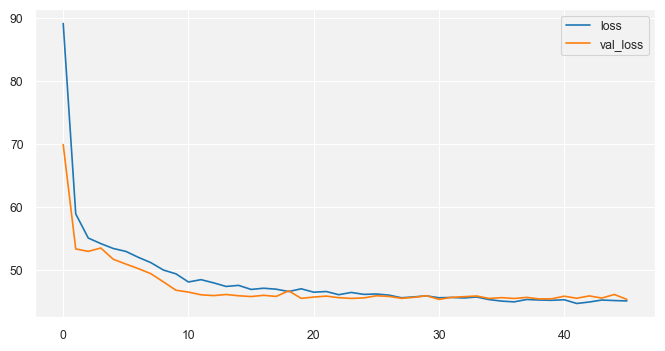

In [63]:
pd.DataFrame(history.history).plot(figsize=(8,4))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

Exemplo de Hashtrick:

```python

        import pandas as pd
        import numpy as np

        # Dados de exemplo
        data = {'state': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                'year': [2000, 2001, 2002, 2001, 2002],
                'pop': [1.5, 1.7, 3.6, 2.4, 2.9]}

        # Criando o DataFrame
        df = pd.DataFrame(data)

        def hash_col(df, col, N):
            # Criando novos nomes de coluna com base nos valores hash
            cols = [col + "_" + str(i) for i in range(N)]
            
            def xform(x):
                # Inicializando uma lista de zeros
                tmp = [0 for i in range(N)]
                # Definindo o índice do valor hash como 1
                tmp[hash(x) % N] = 1
                return pd.Series(tmp, index=cols)
            
            # Aplicando a transformação à coluna especificada
            df[cols] = df[col].apply(xform)
            return df.drop(col, axis=1)

        # Aplicando o Hashing Trick à coluna 'state' com 4 features
        hashed_df = hash_col(df, 'state', 2)

        # Exibindo o DataFrame resultante
        hashed_df


```